# FargoCPT Quickstart

This notebook guides you through how to make the code, run a simulation and plot the results.

First we create a new directory and change to it.

In [1]:
example_name = "100_quickstart"
import os
if not os.path.basename(os.getcwd()) == example_name:
    !mkdir -p $example_name
    os.chdir(example_name)

## Make the code

Make sure the code is built by running make again.

If you have not yet compiled the go, please go to the readme and follow the instructions there.
You can also try to run the following cell directly, but it will only output error messages. This might make debugging harder.

In [2]:
%%timeit -n1 -r1
from sys import platform
if platform in ["linux", "darwin"]:
    !make -j 4 -C ../../src > make.log
else:
    raise RuntimeError(f"Seems like you are not running MacOS or Linux but {platform}. This is unsupported. You are on your own, good luck!")

418 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Preparing a setup file

We'll take the example setup file from the examples directory and modify it in python.
If you want to create setup files for a parameter study, just copy the code and make your own setup creator script.

In [3]:
configfile = "setup.yml"
!cp ../config.yml $configfile

We'll use the `ruamel.yaml` package to read and write the setup file. This can be set up to preserve comments which is very useful if you want to trace your decisions later on.

In [4]:
try:
    import ruamel.yaml
except ImportError:
    raise ImportError("Please install ruamel.yaml with `python3 -m pip install ruamel.yaml`")
yaml = ruamel.yaml.YAML()
with open(configfile, "r") as infile:
    config = yaml.load(infile)

In [5]:
config["nbody"][1]["accretion efficiency"] = "2"
config["MonitorTimestep"] = 0.314 # monitor scalar files around every half orbit
config["Ninterm"] = 20 # write a snapshot every orbit
config["Nsnap"] = 10 # wirte 100 snapshots
# use very low resolution by setting it to 2 cell per scaleheight, cps
try:
    del config["Nrad"]
except KeyError:
    pass
try:
    del config["Naz"]
except KeyError:
    pass

config["cps"] = 2

with open(configfile, "w") as outfile:
    yaml.dump(config, outfile)

## Running the code

We can start fargo using the python interface.

For a production, uncomment the following cell and copy the command to your start script.

In [6]:
# cwd = os.getcwd()
# cmd = f"cd {cwd} && python3 ../../run_fargo -np 1 -nt 4 auto {configfile}"
# print(cmd)

Here, we just launch the code from within the notebook.

Note the `detach=True` parameter.
This sets the simulation up to run in the background.
Use `detach=False` to see the output in the notebook.

Here we opt to detach the simulation to be able to use the widget below to have some live view into the simulation.

In [7]:
import sys
sys.path.append("../../bin")
from fargocpt import run_fargo
run_fargo(2, 1, ["start", configfile], detach=True)

Running command: mpirun -np 2 --report-pid - -x OMP_NUM_THREADS=1 /workspaces/fargocpt/bin/fargocpt start setup.yml
detaching...


Following is an overview widget for the simulation. You can use the slider to scrub through the different snapshots.

In [8]:
import sys
sys.path.append("../../Tools")
from overview import Overview

Run the next cell again to refresh the snapshot list.

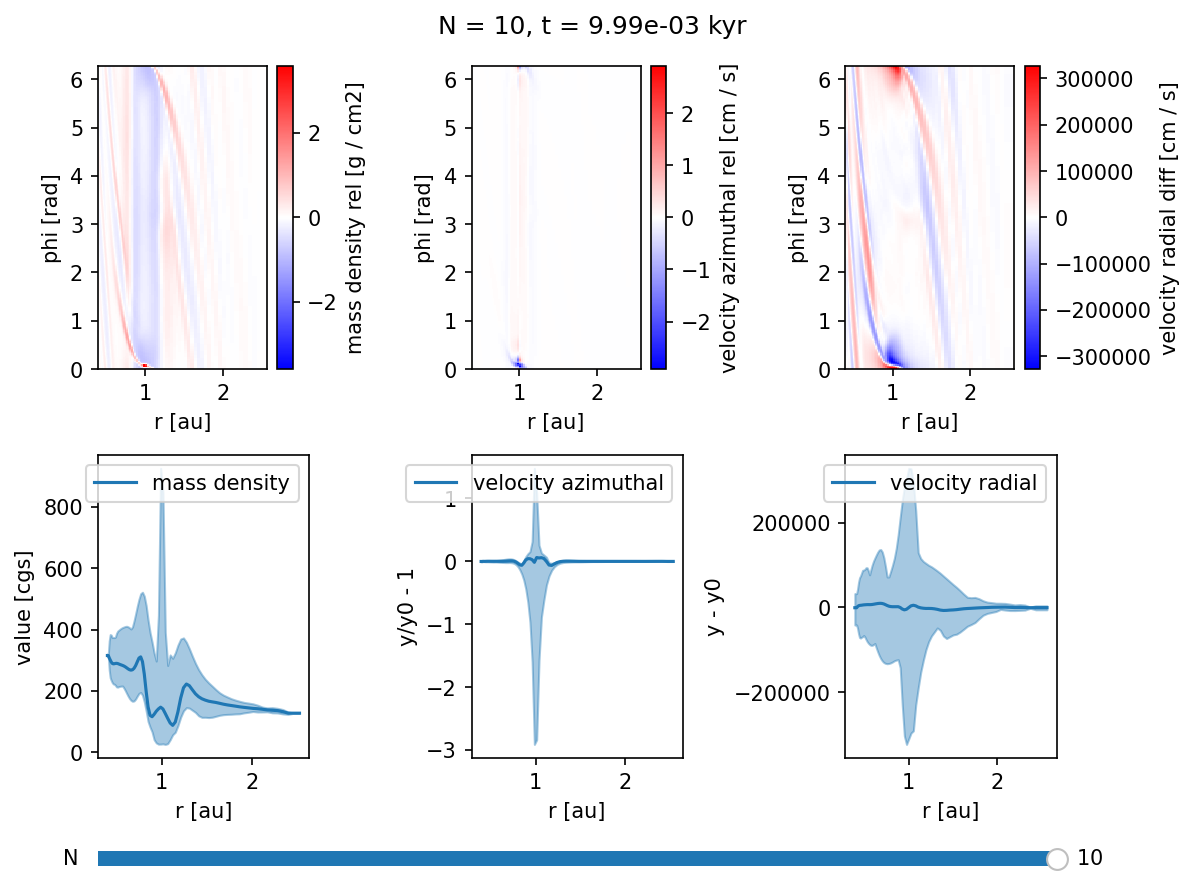

In [11]:
%matplotlib widget
overview = Overview("output/out/", 
                    vars=["2:mass density:rel,rphi",
                          "2:velocity azimuthal:rel,rphi",
                          "2:velocity radial:diff,rphi",
                          "1:mass density:minmax",
                          "1:velocity azimuthal:rel,minmax",
                          "1:velocity radial:diff,minmax"])
overview.create();

Concratulations! You've made it through the quickstart guide.
You should now know enough to run your own experiments using the FargoCPT code.
Happy experimenting!